# <font color='blue'>Introduction to Inverse Problems</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Time-Frequency Example](#Time-Frequency-Example)
1. [Sparse Regularisation](#Sparse-Regularisation)
 * [Sparse Representation](#Sparse-Representation)
 * [Measures of Sparsity](#Measures-of-Sparsity)
 * [Promoting Sparsity](#Promoting-Sparsity)
1. [Hints](#Hints)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy.ndimage import gaussian_filter
from scipy.misc import lena

## <font color='blue'>Introduction</font>

---

A sparse signal is one that is comprised mostly of zeros when expressed in the appropriate basis.

## <font color='blue'>Time-Frequency Example</font>

---

Let's start with a simple sine wave example. We have a time series signal where

$$y = \sin(t)$$

with a sampling rate of 50 and a frequency of 2. We can display this function as follows:

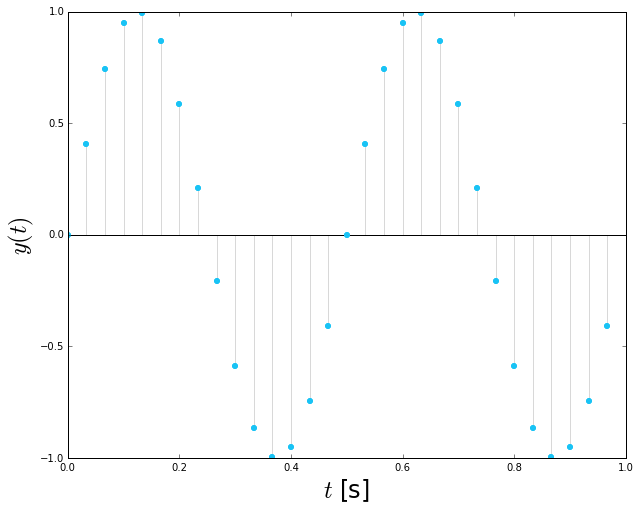

In [2]:
# Set the signal properties.
sampling_rate = 30.0
frequency = 2

# Set a range of t values.
t = np.arange(0, 1, 1.0 / sampling_rate)

# Get the corresponding y values.
y = np.sin(2 * np.pi * frequency * t)

# Display
plt.plot((t, t), (np.zeros(y.size), y), '-', color='#D8D8D8')
plt.plot((0.0, 1.0), (0.0, 0.0), 'k-')
plt.plot(t, y, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$t$ [s]', fontsize=24)
plt.ylabel('$y(t)$', fontsize=24)
plt.show()

We can clearly see that the signal is not sparse as the majority of coefficients are non-zero. However, if we take the fourier transform of this function the signal becomes very sparse indeed.

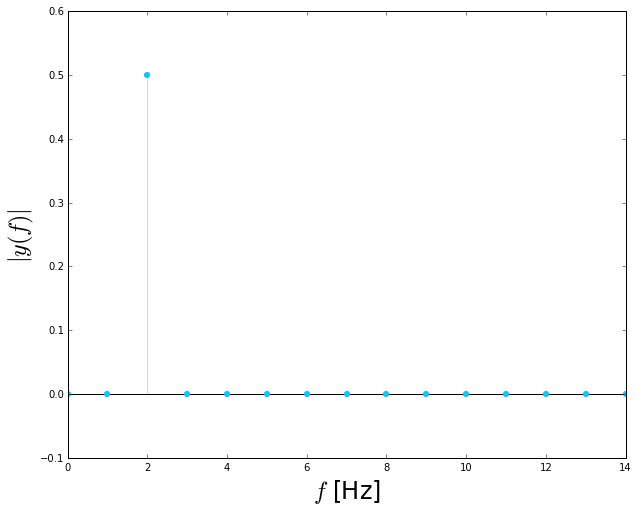

In [3]:
# Get the one-sided frequency range.
f = np.arange(y.size) * sampling_rate / y.size 
f = f[:y.size / 2]

# Calculate the normalised FFT of the signal.
y_fft = np.abs(np.fft.fft(y)) / y.size 
y_fft = y_fft[:y.size / 2]

# Display
plt.plot((f, f), (np.zeros(y_fft.size), y_fft), '-', color='#D8D8D8')
plt.plot((0.0, max(f)), (0.0, 0.0), 'k-')
plt.plot(f, y_fft, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$f$ [Hz]', fontsize=24)
plt.ylabel('$|y(f)|$', fontsize=24)
plt.ylim(-0.1, 0.6)
plt.show()

Now, we have only a single coefficient which is non-zero. So, although in its natural domain our signal does not appear to be sparse we were able to find a sparse representation in a different basis.

So, how can the knowledge that a given signal is sparse in a given domain be useful?

## <font color='blue'>Sparse Regularisation</font>

---

We can use the knowledge that a signal is sparse in a given domain as prior knowledge when solving an inverse problem. This enables us to reduce the parameters space and allows us to converge upon a better and simpler solution.



### <font color='green'>Sparse Representation</font>

A signal $x$ can be respresented as

$$x = \phi\alpha = \sum_{i=1}^n\phi_i\alpha_i$$

where $\alpha$ are the coefficients of $x$ in the dictionary $\phi$. 

### <font color='green'>Measures of Sparsity</font>

The true sparsity of a signal can be measured with the $l_0$ pseudo-norm.

$$\|x\|_0 = \text{Card}(\text{Supp}(x))$$

*i.e.* the number of non-zero elements in the signal. However, this function is non-convex and is computationally hard  to solve. Therefore, in practice the convex $l_1$ norm is used instead.

$$\|x\|_1 = \sum_{i=1}^n |x_i|$$

We can use the to measure the sparsity of our time-frequency example.

In [4]:
# Function to measure the l1 norm.
def l1_norm(signal):
    
    return np.sum(np.abs(signal))

# Get the l1 norm of the time and frequency signals.
print 'The l1 norm of the time signal:', l1_norm(y)
print 'The l1 norm of the frequency signal:', l1_norm(y_fft)

The l1 norm of the time signal: 19.0287289084
The l1 norm of the frequency signal: 0.5


As expected the frequency signal is significantly more sparse.

### <font color='green'>Promoting Sparsity</font>

In order to actually produce solutions that are more sparse one typically performs a thresholding operation in the sparse domain. Standard techniques include hard and soft thresholding.

**Hard Thresholding**

$$HT_{\lambda}(x_i) = \begin{cases} x_i & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

**Soft Thresholding**

$$ST_{\lambda}(x_i) = \begin{cases} x_i - \lambda\text{sign}(x_i) & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

The threshold value, $\lambda$, will vary depending on the type of problem. In the case of denoising $\lambda$ represents an estimate of the noise in the sparse domain. 

In [5]:
# Define a hard thresholding function.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Define a random signal.
x = np.random.ranf((5, 5))

# Set the threshold.
thresh = 0.8

# Threshold the signal.
x_thresh = hard_thresh(x, thresh)

print 'Original Signal.'
print ''
print x
print ''
print 'l1 norm:', l1_norm(x)
print ''
print ''
print 'Thresholded Signal.'
print ''
print x_thresh
print ''
print 'l1 norm:', l1_norm(x_thresh)


Original Signal.

[[ 0.83262108  0.54646881  0.1558383   0.21232386  0.84576818]
 [ 0.72898425  0.76137639  0.21110797  0.09818334  0.18883624]
 [ 0.22282963  0.05121222  0.45210353  0.62493583  0.27766107]
 [ 0.42316015  0.78108712  0.27585847  0.74722408  0.17568807]
 [ 0.85465427  0.81145071  0.20662235  0.85110928  0.72870764]]

l1 norm: 12.065812828


Thresholded Signal.

[[ 0.83262108  0.          0.          0.          0.84576818]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.85465427  0.81145071  0.          0.85110928  0.        ]]

l1 norm: 4.19560351386
